<a href="https://colab.research.google.com/github/zjzsu2000/RL/blob/main/DQN_RL_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random


from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
stock_data1 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/VCYT.csv'))
stock_data2 =  pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AMD.csv'))
stock_data3 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AAPL.csv'))
stock_data4 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NSTG.csv'))
stock_data5 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/NIO.csv'))
stock_data6 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/JYNT.csv'))
stock_data7 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NQSDA.csv'))
stock_data8 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/KODK.csv'))

In [ ]:
NQSDA_Index =  [] 

stock_data7 = stock_data7[stock_data7["Date"].isin(stock_data8.Date.values)]
amount_stock_NQSDA = 100000/stock_data7.Close[0]
for price in stock_data7['Close'].tolist() : 
  NQSDA_Index.append(amount_stock_NQSDA *price)

In [ ]:
df = stock_data8
print(df.head())

         Date  Open  High   Low  Close  Adj Close  Volume
0  2018-01-02  3.05  3.30  3.05   3.15       3.15  159200
1  2018-01-03  3.20  3.25  3.00   3.05       3.05  132400
2  2018-01-04  3.05  3.10  3.00   3.05       3.05  159900
3  2018-01-05  3.10  3.20  3.05   3.15       3.15  256600
4  2018-01-08  3.15  3.20  3.05   3.10       3.10  255700


No handles with labels found to put in legend.


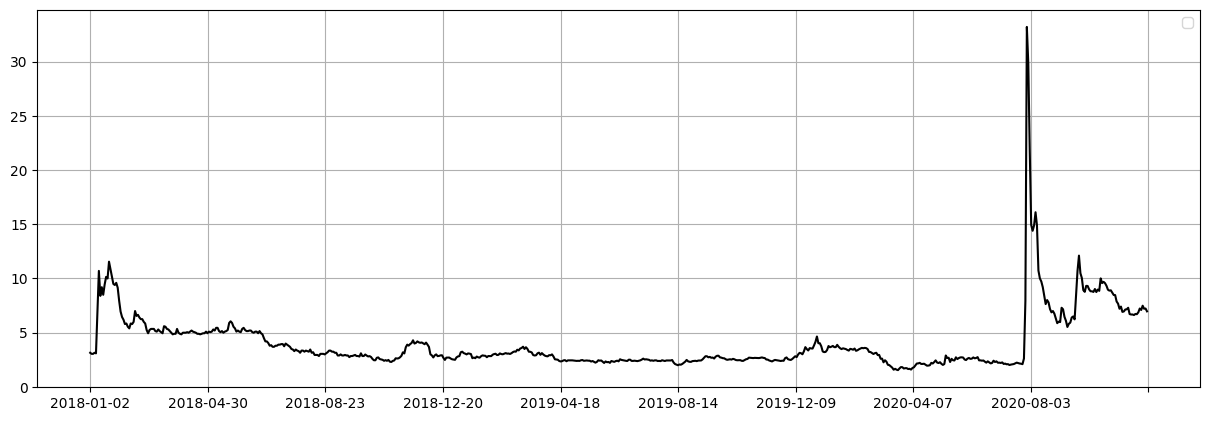

In [ ]:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df['Date'], df['Close'], color='black')
plt.xticks(np.linspace(0, len(df), 10))
plt.legend()
plt.grid()

In [ ]:
df=df.sort_values('Date', ascending=True).reset_index(drop=True)

# caculate MA（moving avarage price）
for day in [5, 10, 21, 30]:
    df['ma'+str(day)] = df.Close.rolling(day).mean()

col = ['ma5', 'ma10', 'ma21', 'ma30']
tmp_df2 = df[col].shift(1)
tmp_df3 = df[col].shift(2)
for tmp_col in col:
    df[tmp_col + '_trend'] = 0
    # tmp_df[tmp_col + '_shift_1'] = tmp_df2[tmp_col]
    # tmp_df[tmp_col _ 'shift_2'] = tmp_df3[tmp_col]
    df['rate1'] = (tmp_df2[tmp_col] - tmp_df3[tmp_col]) / (tmp_df3[tmp_col] + 0.00001)
    df['rate2'] = (df[tmp_col] - tmp_df2[tmp_col]) / (tmp_df2[tmp_col] + 0.00001)
    idx = (df['rate1'] > 0.005) & (df['rate2'] > 0.005)
    df.loc[idx, tmp_col + '_trend'] = 1 # trend going up

    idx = (df['rate1'] < -0.005) & (df['rate2'] < -0.005)
    df.loc[idx, tmp_col + '_trend'] = 2 # # trend going down



df = df.loc[31:].reset_index(drop=True)
df_copy = df.copy()

In [ ]:
df_copy

,Date,Open,High,Low,Close,Adj Close,Volume,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,2018-02-15,6.10,7.25,6.00,7.00,7.00,3216000,6.010,5.990,7.861905,7.581667,1,0.012916,0.017673,0,2,1
1,2018-02-16,6.80,6.95,6.40,6.55,6.55,2078700,6.240,6.000,7.690476,7.698333,1,0.017673,0.015388,0,2,1
2,2018-02-20,6.70,6.88,6.50,6.65,6.65,1172100,6.400,6.045,7.530952,7.815000,1,0.015388,0.015155,0,2,1
3,2018-02-21,6.55,6.70,6.30,6.40,6.40,1112300,6.520,6.105,7.285714,7.925000,1,0.015155,0.014075,1,2,1
4,2018-02-22,6.30,6.50,6.10,6.25,6.25,695300,6.570,6.145,7.066667,7.906667,1,0.014075,-0.002313,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2020-11-18,7.36,7.55,7.08,7.10,7.10,4423000,6.930,6.866,7.270000,7.882333,1,-0.006337,-0.007888,0,2,2
696,2020-11-19,7.08,7.57,7.05,7.49,7.49,4344500,7.082,6.885,7.212381,7.836667,1,-0.007888,-0.005794,0,2,2
697,2020-11-20,7.40,7.43,7.16,7.21,7.21,3840400,7.182,6.934,7.151905,7.743333,1,-0.005794,-0.011910,0,2,2
698,2020-11-23,7.29,7.33,6.95,7.23,7.23,5552500,7.252,6.989,7.092857,7.665000,1,-0.011910,-0.010116,1,2,2


In [ ]:
#todo: Position control strategy
# https://www.investopedia.com/articles/trading/10/create-trading-strategies.asp

def compute_score(index_df, i):
    score = 0
    tmp_rate = (index_df['Close'][i]-index_df['ma5'][i])
    if tmp_rate>=0:
        score += 1
        
    tmp_rate = (index_df['Close'][i]-index_df['ma10'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5
    
    tmp_rate = (index_df['Close'][i]-index_df['ma21'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5

    tmp_rate = (index_df['Close'][i]-index_df['ma30'][i])
    if tmp_rate>=0:
        score += 1
    elif tmp_rate>-0.5:
        score += 0.5
    
    if index_df['ma5_trend'][i] == 1:
        score += 1
    
    if index_df['ma10_trend'][i] == 1:
        score += 1.5
    elif index_df['ma10_trend'][i] == 0:
        score += 0.5

    if index_df['ma21_trend'][i] == 1:
        score += 1.5
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    if index_df['ma21_trend'][i] == 1:
        score += 1
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    return score

# Manual strategy

def print_info(hold_money, hold_market_value, index_df, i, kind, change_amount):
    trade_date = index_df['Date'][i]
    change_amount = round(change_amount,2)
    rate = (index_df['Close'][i] - index_df['Close'][i-1]) / index_df['Close'][i-1]
    rate = round(rate, 2)
    info = str(trade_date)
    if rate > 0:
        info += ', going up ' + str(rate)
    else:
        info += ', going down ' + str(rate)
        
    if kind == 1:
        info += ', buy ' + str(change_amount) 
    
    elif kind == 2:
        info += ', sell ' + str(change_amount) 
    
    info += ',hold money：'+str(round(hold_money,2))+',stocks_value：'+\
    str(round(hold_market_value,2))+',total_market_value：'+str(round(hold_money+hold_market_value,2))
    print(info)


score_list = []
hold_mount = 0
money_init = 100000
hold_money = money_init
hold_market_value = 0
hold_market_value_list = []
hold_money_list = []
all_value_list_manual = []
change_amount = 0
for i in range(len(df)):
    score = compute_score(df, i) / 10    
    #print(str(score))
    if i == 0:
        buy_money = int(money_init * score)
        hold_market_value = buy_money
        hold_money = hold_money - buy_money
        print(str(df['Date'][i])+'buy：'+str(str(buy_money)))
        print(hold_market_value)
    else:
        hold_market_value = hold_market_value * df['Close'][i]/df['Close'][i-1]
        print(hold_market_value)
        if score_list[-1] == score:
            kind = 0
            
        elif score_list[-1] < score: #buy
            if score_list[-1] == 0:
                add_mount = score
            else:
                add_mount = score - score_list[-1]
            
            buy_money = int(hold_money/(1-score_list[-1])* (add_mount))
            hold_market_value += buy_money
            hold_money -= buy_money
            kind = 1
            change_amount = add_mount
            
        else: #sell
            reduce_mount =  score_list[-1] - score
            sell_money = int(hold_market_value/score_list[-1] * (reduce_mount))
            hold_market_value -= sell_money
            hold_money += sell_money
            change_amount = sell_money
            kind = 2
            
        print_info(hold_money, hold_market_value, df, i, kind, change_amount) 
        
    score_list.append(score)
    hold_market_value_list.append(hold_market_value)
    hold_money_list.append(hold_money)
    all_value_list_manual.append(hold_money+hold_market_value)

2018-02-15buy：40000
40000
37428.57142857143
2018-02-16, going down -0.06,hold money：60000,stocks_value：37428.57,total_market_value：97428.57
38000.0
2018-02-20, going up 0.02,hold money：60000,stocks_value：38000.0,total_market_value：98000.0
36571.42857142857
2018-02-21, going down -0.04,hold money：60000,stocks_value：36571.43,total_market_value：96571.43
35714.28571428571
2018-02-22, going down -0.02,hold money：60000,stocks_value：35714.29,total_market_value：95714.29
35714.28571428571
2018-02-23, going down 0.0, sell 8928,hold money：68928,stocks_value：26786.29,total_market_value：95714.29
25714.83428571428
2018-02-26, going down -0.04, sell 12857,hold money：81785,stocks_value：12857.83,total_market_value：94642.83
12536.388428571423
2018-02-27, going down -0.03, sell 8357,hold money：90142,stocks_value：4179.39,total_market_value：94321.39
3750.7332051282006
2018-02-28, going down -0.1,hold money：90142,stocks_value：3750.73,total_market_value：93892.73
3536.405593406589
2018-03-01, going down -0.06

# Q-learning

In [ ]:
class Agent:
    def __init__(self, state_size, window_size, trend, frequency, batch_size , gamma = 0.98,epsilon = 0.5, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.00001):
        self.state_size = state_size #size of the state
        self.window_size = window_size #window size, buy stop before the window size days
        self.half_window = window_size // 2
        self.trend = trend  #data
        self.frequency = frequency 
        self.action_size = 3 #there are three action: buy, sell and hold
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000) 
        self.inventory = [] 

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay


        tf.compat.v1.reset_default_graph()
        #tf.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        tf.compat.v1.disable_eager_execution()
        #self.sess = tf.InteractiveSession() 
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size]) #state
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size]) #action
        #print(self.X)
        feed = tf.keras.layers.Dense(256, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(128, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(64, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(32, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(16, activation ='relu')(self.X)
        feed = tf.keras.layers.Dense(8, activation ='relu')(self.X)
        self.logits = tf.keras.layers.Dense( self.action_size)(feed) #calulate the prob of 3 different action
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits)) #calculate the loss function
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(self.cost) 
        self.total_money_list=[]
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state, is_test=False): #choose action
        if not is_test:
          if random.random() <= self.epsilon: #if less than epsilon will use random range
            return random.randrange(self.action_size)
		#else choose the best action
        return np.argmax( 
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t): #get the state in time t
        window_size = self.window_size + 1
        d = t - window_size + 1
		    #initial window size not enough, use 0 instead of window size
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i]) #reward of each step
        return np.array([res]) #assign state 

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])#memory
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        
		#Q calulate
		#[state, action, reward, next_state, done]
		# initial Q table
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
		#update Q table
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done: 
                target[action] += self.gamma * np.amax(Q_new[i])
			
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
		#adjust the epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        #print(Q)
        return cost

    def test(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = [] 
        market_value = initial_money
        hold_money = initial_money
        stock_value = 0
        hold_num = 0
        self.total_money_list.append(initial_money)
        state = self.get_state(0) 
        for t in range(0, len(self.trend) - 1):
            if t%self.frequency!=0 :
              stock_value = self.trend[t] * hold_num *100
              market_value = stock_value + hold_money 
              self.total_money_list.append(market_value)
              continue                           
            action = self.act(state, True) #do action base on state
            next_state = self.get_state(t + 1) #get next state
            #action=1 buy
            if action == 1 and hold_money >= self.trend[t]*100 and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t]) #buy
                #initial_money -= self.trend[t] 
                buy_num = int(hold_money // self.trend[t] // 100)
                hold_num += buy_num
                stock_value += self.trend[t]*100 * buy_num
                hold_money -= self.trend[t]*100 * buy_num

                states_buy.append(t) #record the transcation 
                print('day %d: buy %d unit at price %f'% (t,buy_num, self.trend[t]))
                
            #action=2 sell
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0) #sell
                #initial_money += self.trend[t] 
                states_sell.append(t) #record the transcation 
                hold_money += self.trend[t] * hold_num * 100          
                stock_value =0  
                market_value = stock_value + hold_money
              	#calculate the invest
                try: 
                    invest = ((self.trend[t] - bought_price) / bought_price) 
                except:
                    invest = 0
                    
                print(
                    'day %d, sell %d unit at price %f, investment %f %%, total balance %f,'
                      % (t, hold_num, self.trend[t], invest, market_value)
                )
                hold_num = 0
            
            stock_value = self.trend[t] * hold_num *100
            market_value = stock_value + hold_money
            total_profit = market_value - initial_money
            #invest = ((market_value - initial_money) / initial_money)

            # self.memory.append((state, action, invest, 
            #                         next_state, starting_money < initial_money))
                                 
            self.total_money_list.append(market_value)
            state = next_state 

		#calculate the invest
        invest_all = ((market_value - starting_money) / starting_money)* 100
        total_gains = market_value - starting_money
        
        return states_buy, states_sell, total_gains, invest_all
        
    def train(self, iterations, checkpoint, initial_money):
		
        for i in range(iterations):
            #print(str(i))
            total_profit = 0 
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            last_value = initial_money
            market_value = initial_money
            hold_money = initial_money
            stock_value = 0
            hold_num = 0

            for t in range(0, len(self.trend) - 1, self.frequency):
                #print(str(i),t)
                action = self.act(state)
                next_state = self.get_state(t + 1)
                #print(next_state)
                if action == 1 and hold_money >= self.trend[t]*100 and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    buy_num = int(hold_money// self.trend[t] // 100)#buy stock number
                    hold_num += buy_num
                    stock_value += self.trend[t]*100 * buy_num
                    hold_money -= self.trend[t]*100 * buy_num
                    #print(stock_value,hold_money)
                
                elif action == 2 and len(inventory) > 0:
                    # bought_price = inventory.pop(0)
                    # total_profit += self.trend[t] - bought_price
                    # starting_money += self.trend[t]
                    hold_money += self.trend[t]* hold_num*100 
                    hold_num = 0
                    stock_value = 0
                    #print(stock_value,hold_money)
                    
                stock_value = self.trend[t] * hold_num *100
                market_value = stock_value + hold_money
                total_profit = market_value - initial_money
                invest = ((market_value - last_value) / last_value)
                last_value = market_value
                #print(stock_value,market_value,total_profit,invest,last_value)

                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                #print(self.batch_size)
                batch_size = min(self.batch_size, len(self.memory))
                #print(batch_size)
                cost = self.replay(batch_size)
                #print(cost)
            
            if (i+1) % checkpoint == 0:
                invest_all = ((market_value - initial_money) / initial_money)
                #if invest_all > 1.0:
                #    break  
                print('epoch: %d, total rewards: %f, cost: %f, total money: %f'%(i + 1, total_profit, cost, market_value))

# DQN with pytorch

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(1)
torch.manual_seed(41)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        units = 32
        self.fc1 = nn.Linear(input_shape, units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(units, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = torch.tensor(reward_decay, dtype=torch.float)
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))
        
        self.net = DQN(n_features, n_actions).to(device)
        self.tgt_net = DQN(n_features, n_actions).to(device)
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)


    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation, train=True):
        # to have batch dimension when feed into tf placeholder
        observation = [observation[np.newaxis, :]]
        observation = torch.tensor(observation, dtype=torch.float32).to(device)
        
        if np.random.uniform() < self.epsilon or (train == False):
            # forward feed the observation and get q value for every actions
            actions_value = self.net(observation).detach().cpu().squeeze(0)
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        self.net.train()
        self.tgt_net.train()
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.tgt_net.load_state_dict(self.net.state_dict())
            # print('\ntarget_params_replaced\n')
            
        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        
        batch_memory = self.memory[sample_index, :]
        s_ = torch.tensor(batch_memory[:, -self.n_features:], dtype=torch.float32).to(device)
        s = torch.tensor(batch_memory[:, :self.n_features], dtype=torch.float32).to(device)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = torch.tensor(batch_memory[:, self.n_features + 1], dtype=torch.float32)
        
        q_next = self.tgt_net(s_)
        q_eval = self.net(s)

        # # change q_target w.r.t q_eval's action
        q_target = q_eval.clone()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        max_, _ = torch.max(q_next, dim=1)
        q_target[batch_index, eval_act_index] = reward + self.gamma * max_
        
        # loss backpropogation
        self.optimizer.zero_grad()
        loss = nn.MSELoss()(q_eval, q_target)
#        print(loss)
        loss.backward()
        self.optimizer.step()
        
        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

In [ ]:
#Env

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class stock_env:
    
    def __init__(self, df, init_money=100000, window_size=6):
        
        self.n_actions = 3 
        self.n_features = window_size   
        self.trend = df['Close'].values # close price
        self.df = df #dataset
        self.init_money = init_money 
        
        self.window_size = window_size 
        self.half_window = window_size // 2
        
        self.buy_rate = 0.0003  
        self.buy_min = 5  # min buying fee
        self.sell_rate = 0.0003  # selling fee
        self.sell_min = 5  # max buying fee
        self.stamp_duty = 0.001  # tax
        #print(len(self.trend))
    def reset(self):
        self.hold_money = self.init_money 
        self.buy_num = 0 
        self.hold_num = 0 
        self.stock_value = 0 
        self.market_value = 0 
        self.last_value = self.init_money # last day market value
        self.total_profit = 0 # total profit
        self.t = self.window_size // 2 # time
        self.reward = 0 # reward
        # self.inventory = []
        
        self.states_sell = [] 
        self.states_buy = [] 
        
        self.profit_rate_account = [] 
        self.market_value_list = [] 
        self.profit_rate_stock = [] 
        return self.get_state(self.t)
    
    def get_state(self, t): #get state at t time
        
        window_size = self.window_size + 1
        d = t - window_size + 1
		
        # block = self.trend[d : t + 1] if d >= 0 else (-d * [self.trend[0]] + self.trend[0 : t + 1])
        block = []
        if d<0:
            for i in range(-d):
                block.append(self.trend[0])
            for i in range(t+1):
                block.append(self.trend[i])
        else:
            block = self.trend[d : t + 1]
                
            
        res = []
        for i in range(window_size - 1):
            res.append((block[i + 1] - block[i])/(block[i]+0.0001)) #每步收益
        # res = []
            
        # if self.hold_num > 0:
        #     res.append(1)
        # else:
        #     res.append(0)
            
        # res.append((self.df['close'][t] - self.df['ma21'][t]) / self.df['ma21'][t])
        # res.append((self.df['close'][t] - self.df['ma13'][t]) / self.df['ma13'][t])
        # res.append((self.df['close'][t] - self.df['ma5'][t]) / self.df['ma5'][t])
        # res.append((self.df['vol'][t] - self.df['ma_v_21'][t]) / self.df['ma_v_21'][t])
        return np.array(res) #states 
    
    def buy_stock(self):       
        # buy
        self.buy_num = self.hold_money // self.trend[self.t] // 100 # 买入手数
        self.buy_num = self.buy_num * 100
        
        # fee
        tmp_money = self.trend[self.t] * self.buy_num
        service_change = tmp_money * self.buy_rate
        if service_change < self.buy_min:
            service_change = self.buy_min
        
        if service_change + tmp_money > self.hold_money:
            self.buy_num = self.buy_num - 100
        tmp_money = self.trend[self.t] * self.buy_num
        service_change = tmp_money * self.buy_rate
        if service_change < self.buy_min:
            service_change = self.buy_min
            
        self.hold_num += self.buy_num
        self.stock_value += self.trend[self.t] * self.buy_num
        self.hold_money = self.hold_money - self.trend[self.t] * \
            self.buy_num - service_change
        self.states_buy.append(self.t)
    
    def sell_stock(self, sell_num):
        tmp_money = sell_num * self.trend[self.t]
        service_change = tmp_money * self.sell_rate
        if service_change < self.sell_min:
            service_change = self.sell_min
        stamp_duty = self.stamp_duty * tmp_money
        self.hold_money = self.hold_money + tmp_money - service_change - stamp_duty
        self.hold_num = 0
        self.stock_value = 0
        self.states_sell.append(self.t)
        
    def trick(self):
        if self.df['Close'][self.t] >= self.df['ma21'][self.t]:
            return True
        else:
            return False
    
    def step(self, action, show_log=False, my_trick=False):
        
        if action == 1 and self.hold_money >= (self.trend[self.t]*100 + \
            max(self.buy_min, self.trend[self.t]*100*self.buy_rate)) and self.t < (len(self.trend) - self.half_window):
            buy_ = True
            if my_trick and not self.trick(): 
                # ma filter
                buy_ = False
            if buy_ : 
                self.buy_stock()
                if show_log:
                    print('day:%d, buy price:%f, buy num:%d, hold num:%d, hold money:%.3f'% \
                          (self.t, self.trend[self.t], self.buy_num, self.hold_num, self.hold_money))
        
        elif action == 2 and self.hold_num > 0:
            # selling stock         
            self.sell_stock(self.hold_num)
            if show_log:
                print(
                    'day:%d, sell price:%f, total balance %f,'
                    % (self.t, self.trend[self.t], self.hold_money)
                )
        else:
            if my_trick and self.hold_num>0 and not self.trick():
                self.sell_stock(self.hold_num)
                if show_log:
                    print(
                        'day:%d, sell price:%f, total balance %f,'
                        % (self.t, self.trend[self.t], self.hold_money)
                    )
                    
        self.stock_value = self.trend[self.t] * self.hold_num

        self.market_value = self.stock_value + self.hold_money 
        self.total_profit = self.market_value - self.init_money
        
        reward = (self.trend[self.t + 1] - self.trend[self.t]) / self.trend[self.t]
        if np.abs(reward)<=0.015:
            self.reward = reward * 0.2
        elif np.abs(reward)<=0.03:
            self.reward = reward * 0.7
        elif np.abs(reward)>=0.05:
            if reward < 0 :
                self.reward = (reward+0.05) * 0.1 - 0.05
            else:
                self.reward = (reward-0.05) * 0.1 + 0.05
        
        # reward = (self.trend[self.t + 1] - self.trend[self.t]) / self.trend[self.t]
        if self.hold_num > 0 or action == 2:                                
            self.reward = reward    
            if action == 2:
                self.reward = -self.reward
        else:
            self.reward = -self.reward * 0.1
            # self.reward = 0
        
        self.last_value = self.market_value
        self.market_value_list.append(self.market_value)
        self.profit_rate_account.append((self.market_value - self.init_money) / self.init_money)
        self.profit_rate_stock.append((self.trend[self.t] - self.trend[0]) / self.trend[0])
        done = False
        self.t = self.t + 1
        if self.t == len(self.trend) - 2:
            done = True
        s_ = self.get_state(self.t)
        reward = self.reward
        
        return s_, reward, done
    
    def get_info(self):
        return self.states_sell, self.states_buy, self.profit_rate_account, self.profit_rate_stock  
    
    def draw(self, save_name1, save_name2):
        # draw the result
        states_sell, states_buy, profit_rate_account, profit_rate_stock = self.get_info()
        invest = profit_rate_account[-1]
        total_gains = self.total_profit
        close = self.trend
        fig = plt.figure(figsize = (15,5))
        plt.plot(close, color='r', lw=2.)
        plt.plot(close, 'v', markersize=8, color='k', label = 'selling signal', markevery = states_sell)
        plt.plot(close, '^', markersize=8, color='m', label = 'buying signal', markevery = states_buy)        
        plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
        plt.legend()
        #plt.savefig(save_name1)
        plt.show()
        
        fig = plt.figure(figsize = (15,5))
        plt.plot(self.market_value_list, label='DQN')
        plt.plot(profit_rate_stock, label='buy&hold')
       # plt.plot(NQSDA_Index[500:], label='NQSDA_Index')
        plt.legend()
        #plt.savefig(save_name2)
        plt.show()

In [ ]:
def game_step(env,agent,observation, step=None, train=True, show_log=False, my_trick=False):
    
    # RL choose action based on observation
    action = agent.choose_action(observation, train)

    # RL take action and get next observation and reward
    observation_, reward, done = env.step(action, show_log=show_log, my_trick=my_trick)

    agent.store_transition(observation, action, reward, observation_)
    # print("total profit:%.3f" % env.total_profit, end='\r')
    if step and (step > 200) and (step % 5 == 0):
      agent.learn()

    # swap observation
    observation = observation_
    
    return observation, done
    

def run_DQN(env,agent,epcho, check_point):
    step = 0
    for episode in range(epcho):
        # initial observation
        observation = env.reset()

        while True:
            
            observation, done = game_step(env, agent,observation, step=step)
            # print(observation)
            # break while loop when end of this episode
            if done:
                break
            step += 1
        if episode % check_point == 0:
          print('epoch:%d, total_profit:%.3f' % (episode, env.total_profit))
        # BackTest(False)


def BackTest_DQN(env, agent,show_log=True, my_trick=False):
    observation = env.reset()
    # step=0
    while True:
        observation, done = game_step(env, agent,observation, train=False, 
                                      show_log=show_log, my_trick=my_trick)
        # break while loop when end of this episode
        if done:
            break
    print('total_profit:%.3f' % (env.total_profit))
    return env


In [ ]:
def back_test(df,initial_money,window_size,frequency,batch_size,iterations,checkpoint,gamma = 0.98,epsilon = 0.5, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.02): 
    trend = df.Close.values.tolist() #using close price to test  
    agent_Q = Agent(state_size = window_size, 
                  window_size = window_size, 
                  trend = trend, 
                  frequency = frequency, 
                  batch_size = batch_size,
                  gamma = gamma,
                  epsilon = epsilon, 
                  epsilon_min = epsilon_min,
                  epsilon_decay = epsilon_decay, 
                  lr = lr)
    agent_Q.train(iterations = iterations, checkpoint = checkpoint, initial_money = initial_money)
       

    states_buy, states_sell, total_gains, invest = agent_Q.test(initial_money = initial_money)
    
    env_DQN = stock_env(df_copy.iloc[0:len(df_copy)-1])
    agent_DQN = DeepQNetwork(env_DQN.n_actions, env_DQN.n_features,
                      learning_rate= 0.01,
                      reward_decay= epsilon_decay,
                      e_greedy=gamma,
                      replace_target_iter=200,
                      memory_size=4000,
                      batch_size=batch_size,                      
                      )
    run_DQN(env_DQN,agent_DQN, iterations,checkpoint)

    env_DQN = stock_env(df_copy.iloc[0:len(df_copy)-1].reset_index(drop=True))  
    env_DQN = BackTest_DQN(env_DQN, agent_DQN,show_log=True)
   
    fig = plt.figure(figsize = (15,5))
    plt.plot(trend, color='r', lw=2.)
    plt.plot(trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('gamma: %.3f,epsilon: %.3f,epsilon_min: %.3f,epsilon_decay: %.3f,lr: %.6f\n'%(gamma,epsilon,epsilon_min,epsilon_decay,lr)+'total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

     #buy first day and hold strategy
    buy_hold_strategy_value =  [] 
    amount_stock = initial_money/trend[0]
    for price in trend : 
      buy_hold_strategy_value.append(amount_stock *price)
    #print(len(buy_hold_strategy_value))
    #print(len(agent.total_money_list))

    fig = plt.figure(figsize = (15,5))
    plt.plot(buy_hold_strategy_value, color='r', lw=2.,label="buy_hold_strategy%.1f"%(buy_hold_strategy_value[-1]))
    plt.plot(all_value_list_manual, color='y', lw=2.,label="Manual strategy%.1f"%(all_value_list_manual[-1]))
    plt.plot(agent_Q.total_money_list, color='b', lw=2.,label="QL_agent_value%.1f"%(agent_Q.total_money_list[-1]))
    plt.plot(env_DQN.market_value_list, color='orange', lw=2.,label="DQN_agent_value%.1f"%(env_DQN.market_value_list[-1]))
    plt.plot(NQSDA_Index, color='g', lw=2.,label="NQSDA_value" )
    plt.plot()
    plt.ylabel("total value")
    plt.xlabel("day")
    plt.legend()
    plt.show()

epoch: 10, total rewards: -94082.000700, cost: 0.206681, total money: 5917.999300
epoch: 20, total rewards: -94179.000600, cost: 0.216130, total money: 5820.999400
epoch: 30, total rewards: -93543.000700, cost: 0.229968, total money: 6456.999300
epoch: 40, total rewards: -93350.000800, cost: 0.238296, total money: 6649.999200
epoch: 50, total rewards: -93083.000700, cost: 0.234541, total money: 6916.999300
epoch: 60, total rewards: -92981.000800, cost: 0.225579, total money: 7018.999200
epoch: 70, total rewards: -89047.001200, cost: 0.207667, total money: 10952.998800
epoch: 80, total rewards: -91864.000800, cost: 0.189008, total money: 8135.999200
epoch: 90, total rewards: -93217.000700, cost: 0.173603, total money: 6782.999300
epoch: 100, total rewards: -88681.001300, cost: 0.155705, total money: 11318.998700
epoch: 110, total rewards: -89302.001200, cost: 0.136172, total money: 10697.998800
epoch: 120, total rewards: -84360.001200, cost: 0.113218, total money: 15639.998800
epoch: 13

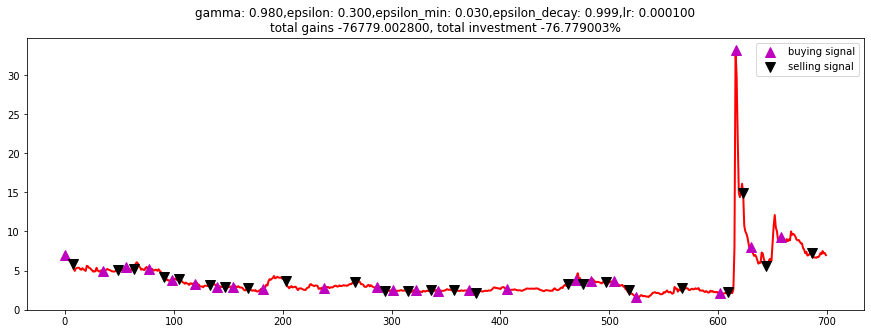

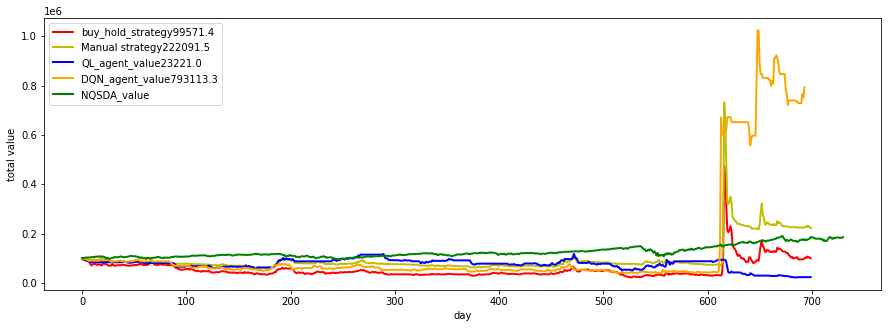

In [ ]:
back_test(df,initial_money = 100000, window_size = 30, frequency = 7, batch_size = 32,iterations = 200, checkpoint = 10,gamma = 0.98,epsilon = 0.3, epsilon_min = 0.03,epsilon_decay = 0.999, lr =0.0001)

In [ ]:
len(df_copy)

700